# XPCS&XSVS Pipeline for Mulit-SAXS|Gi-SAXS Runs
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [29]:
from chxanalys.chx_packages import *
from chxanalys.chx_xpcs_xsvs_jupyter import run_xpcs_xsvs_single
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Control Multi-Runs Parameters

In [30]:
scat_geometry = 'ang_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

force_compress = False #True   #force to compress data 
bin_frame = True  #generally make bin_frame as False

para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True #False #True #True #False    #run  two-time
run_four_time = True #False   #run  four-time
run_xsvs= True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 0#3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_pipe'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 
if scat_geometry == 'ang_saxs':
    run_xsvs= False;run_waterfall=False;run_two_time=False;run_four_time=False;run_t_ROI_Inten=False; 
     
    

In [31]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [32]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


In [33]:

uid_average=  'SAXS_Test_120116' #give a meaningful folder name 
uid_average=  'GiSAXS_Test_120116' #give a meaningful folder name 
uid_average=  'Flow_SAXS_Test_120116' #give a meaningful folder name 

data_dir = os.path.join( data_dir0, uid_average +'/')
os.makedirs(data_dir, exist_ok=True)
print ( data_dir )
uid_average = 'uid=' + uid_average

/XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [34]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name =  'Nov16_4M-GiSAXS_mask.npy'
elif scat_geometry == 'saxs' or scat_geometry =='ang_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name = 'Nov28_4M_SAXS_mask.npy'
    
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name = 'Dec3_4M_SAXS_mask.npy'  #for flow test, uid = 99aaa04f

<IPython.core.display.Javascript object>


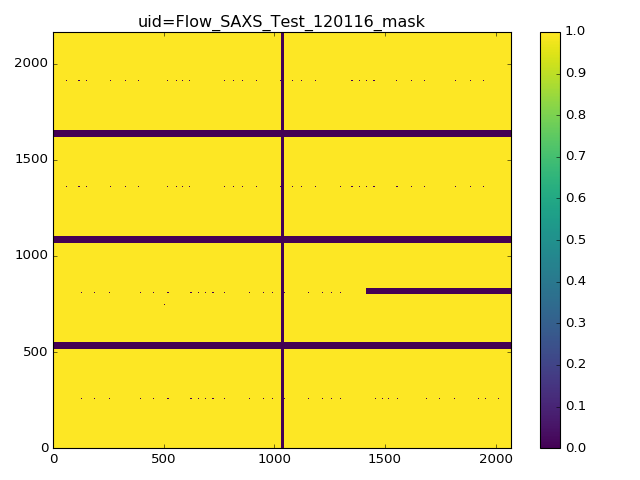

In [35]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s_mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = '%s_mask'%uid_average, save=True, path=data_dir)
mask_load=mask.copy()

## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [36]:
start_time, stop_time = '2016-12-1  16:30:00', '2016-12-1  16:31:50' #for 10 nm, 20, for saxs test purpose
start_time, stop_time = '2016-11-18  16:20:00', '2016-11-18  16:35:50' #  for gisaxs test purpose 
start_time, stop_time = '2016-12-3  18:51:00', '2016-12-3  19:13:00'  #for flow test purpose

sids, uids, fuids = find_uids(start_time, stop_time)
print( uids )
uid = uids[0]
uidstr = 'uid=%s'%uid

Totally 5 uids are found.
['99aaa04f' 'dd781ed5' '073f83ac' '57c3362b' '667327b7']


In [37]:
guids, buids = check_bad_uids( uids, mask, img_choice_N = 3 )
print( 'The good uids are: %s.\nThe good uids length is %s.'%(guids, len(guids)) )

hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5
hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5
hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5
hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5
The total and bad uids number are 5 and 0, repsectively.
The good uids are: ['99aaa04f' 'dd781ed5' '073f83ac' '57c3362b' '667327b7'].
The good uids length is 5.


In [38]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]

# Don't Change these lines below here

In [39]:
md = get_meta_data( uid )

In [40]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

imgsa = apply_mask( imgs, mask )

hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 1000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [41]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 99aaa04f
number of images--> 1000
uid--> 99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be
scan_id--> 11068
start_time--> 2016-12-03 18:51:37
stop_time--> 2016-12-03 18:52:12
sample--> S3
Measurement--> S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
acquire period--> 0.001339999958872795
exposure time--> 0.0013299999991431832
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata Due to Wrong Input

In [42]:
inc_x0 = None
inc_y0=   None

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

Ldet--> 4890.0
timeperframe--> 0.00134
center--> [816, 1443]
path--> /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/
lambda_--> 1.28481
exposuretime--> 0.0013299999991431832
dpix--> 0.0750000035623
uid--> uid=99aaa04f


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [43]:
img_choice_N = 3
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded fdata_diror this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


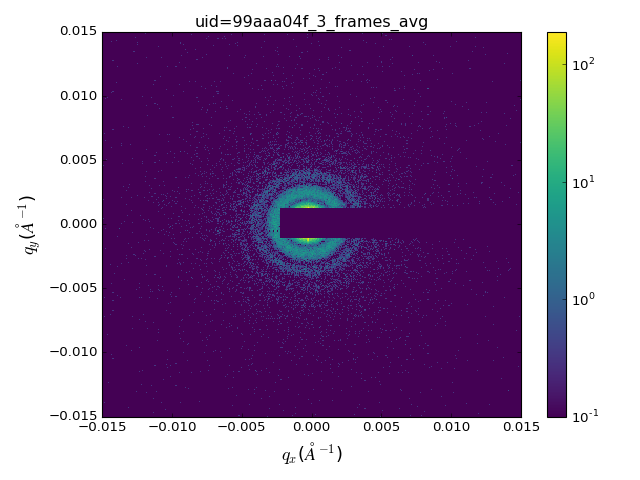

In [44]:
if scat_geometry == 'gi_saxs':
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
 image_name= uidstr + '_%s_frames_avg'%img_choice_N,  save=True, path=data_dir) 
else:    
    show_saxs_qmap( avg_img, setup_pargs, width=200, show_pixel = False,
       vmin=.1, vmax= np.max(avg_img), logs=True, image_name= uidstr + '_%s_frames_avg'%img_choice_N )

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

# SAXS Scattering Geometry

<IPython.core.display.Javascript object>


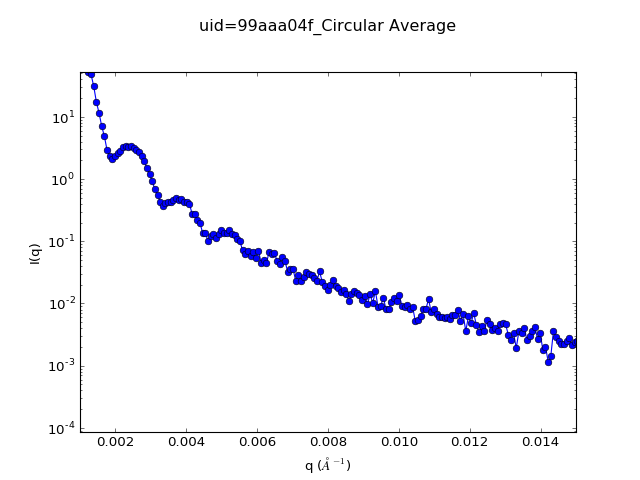

In [45]:
if scat_geometry =='saxs' or 'ang_saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    
    xlim= [ 0.001, 0.015] #None
    
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, xlim= xlim )    
    
    pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
    pd.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )
    mask =np.array( mask * hmask, dtype=bool) 
    #show_img( mask )

In [46]:
if scat_geometry =='saxs' or 'ang_saxs':
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  

In [47]:
if scat_geometry  =='saxs' or 'ang_saxs':
    
    uniformq = True #False    #True #False   
    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        ring_width = 0.0002    
        number_rings= 1    
        qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
        edges = get_non_uniform_edges(  qcenters, ring_width, number_rings )    
        inner_radius= None
        outer_radius = None
        ring_width = None
        num_rings = None   
        gap_ring_number=None
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:  
        inner_radius= 0.002  # 0.005 #0.006  #16
        outer_radius = 0.003 #0.04 #0.05  #112    
        num_rings = 5  #12
        gap_ring_number = 6
        ring_width =   0.0002 #  ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None        
        qcenters = None
        number_rings= None

<IPython.core.display.Javascript object>


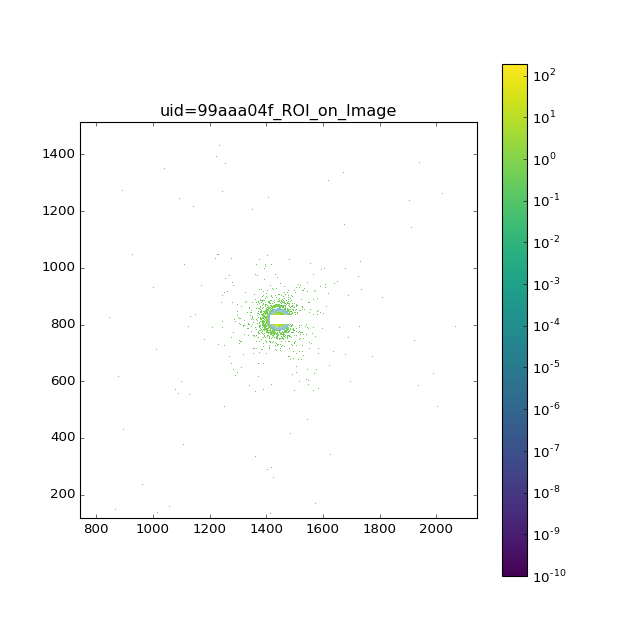

In [48]:
if scat_geometry =='saxs' or 'ang_saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = ring_width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 4)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 
    qval_dict = get_qval_dict( np.round(qr, 4)  ) 

<IPython.core.display.Javascript object>


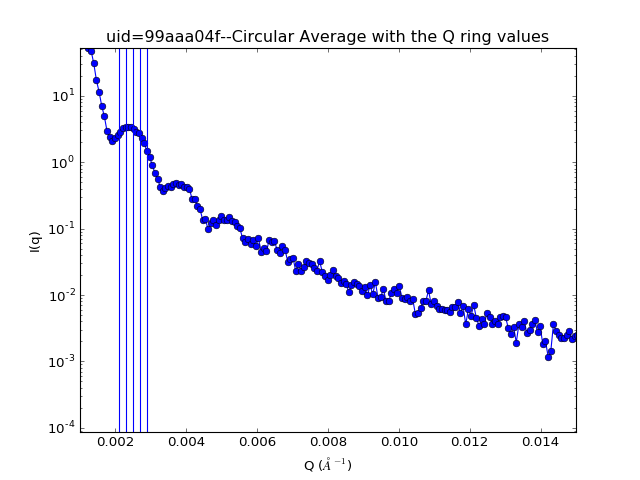

In [49]:
if scat_geometry  =='saxs' or 'ang_saxs':    
    xlim= [ 0.001, 0.015] #None    
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=xlim,  save=True, path=data_dir)      

# Ang_SAXS (flow) Scattering Geometry

### Create flow vertical/parallel array mask

In [50]:
if scat_geometry =='ang_saxs': 
    width_angle_v = 2
    angle_v = 132
    num_angles_v =   1 
    inner_angle_v=  angle_v -  width_angle_v
    outer_angle_v =  angle_v + width_angle_v            
    roi_mask_v, qval_dict_v =  get_seg_from_ring_mask( inner_angle_v, outer_angle_v,
                                            num_angles_v, width_angle_v, center, roi_mask, qr ) 
    
    width_angle_p = 2
    angle_p = 42
    num_angles_p =   1  
    inner_angle_p=  angle_p -  width_angle_p
    outer_angle_p =  angle_p + width_angle_p      
    roi_mask_p, qval_dict_p =  get_seg_from_ring_mask( inner_angle_p, outer_angle_p,
                                            num_angles_p, width_angle_p, center, roi_mask, qr ) 

 

    #show_ROI_on_image( avg_img, seg_mask_v, center, label_on = True, rwidth=120, alpha=.9, 
    #              vmax=30, save=True, path=data_dir, uid=uid + '_Vert_')

# GiSAXS Scattering Geometry

In [51]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0 = 1473
    inc_y0 = 372
    refl_x0 = 1473
    refl_y0 = 730
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

In [52]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.025
    qz_end = 0.04
    qz_num= 3
    gap_qz_num = 1
    
    qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    qr_start =  0.0025
    qr_end = 0.07
    qr_num = 14
    gap_qr_num = 5
    qr_width = ( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


In [53]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = True #False  #if True to define another line; else: make it False
    
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.04
        qz_end2 = 0.050
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = (qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        qr_start2 =  0.002
        qr_end2 = 0.064
        qr_num2 = 10
        gap_qr_num2 = 5
        qr_width2 = ( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )
        
        show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )
        
        ## Get 1D Curve (Q||-intensity¶)
        qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0,  setup_pargs=setup_pargs )
        qr_1d_pds_label = list( qr_1d_pds.columns )
        plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

# Configure Multi-Run

## Control Multi-Runs Parameters


In [54]:
good_start = 5

In [55]:
run_pargs=  dict(   
    
    scat_geometry = scat_geometry,    
    force_compress =  force_compress,    #force to compress data 
    para_compress = para_compress,             #parallel compress
    run_fit_form = run_fit_form,             #run fit form factor  
    run_waterfall = run_waterfall,             #run waterfall analysis
    run_t_ROI_Inten = run_t_ROI_Inten,          #run  ROI intensity as a function of time
    run_one_time = run_one_time,      #run  one-time
    fit_g2_func = fit_g2_func,    
    run_two_time = run_two_time,    #run  two-time
    run_four_time = run_four_time,     #run  four-time
    run_xsvs=run_xsvs,            #run visibility analysis
    att_pdf_report = att_pdf_report,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  good_start,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = use_sqnorm,  #if True, use sq to normalize intensity
    use_imgsum_norm=use_imgsum_norm,#if True use imgsum to normalize intensity for one-time calculatoin
    pdf_version = pdf_version #for pdf report name    
                )
    
if scat_geometry == 'saxs' or 'ang_saxs':
    add_conf = dict(inc_x0=inc_x0, inc_y0=inc_y0, uniformq = uniformq, 
                    inner_radius= inner_radius, ring_width = ring_width, outer_radius =outer_radius,
                    num_rings =num_rings, gap_ring_number = gap_ring_number, qcenters=qcenters,
                    number_rings=number_rings,  )    
    
    if scat_geometry == 'ang_saxs':
        add_conf_ = dict(width_angle_v=width_angle_v,angle_v=angle_v,num_angles_v=num_angles_v,
                         width_angle_p=width_angle_p,angle_p=angle_p,num_angles_p=num_angles_p,
                        ) 
        add_conf.update( add_conf_ )
    
elif scat_geometry == 'gi_saxs':
    run_pargs['define_second_roi'] = define_second_roi
    add_conf = dict(inc_x0=inc_x0,inc_y0=inc_y0,refl_x0=refl_x0,refl_y0=refl_y0,
                    qz_start=qz_start,qz_end=qz_end,qz_num=qz_num,gap_qz_num=gap_qz_num,
                    qr_start=qr_start,qr_end=qr_end,qr_num=qr_num,gap_qr_num=gap_qr_num,)
    if define_second_roi:
        add_conf2 =  dict(qz_start2=qz_start2,qz_end2=qz_end2,qz_num2=qz_num2,gap_qz_num2=gap_qz_num2,
                    qr_start2=qr_start2,qr_end2=qr_end2,qr_num2=qr_num2,gap_qr_num2=gap_qr_num2,)
        add_conf.update(  add_conf2 )
        
run_pargs.update( add_conf )


# Do loop here

In [69]:
do_loop =  False #True #False #True #False
if do_loop:
    multi_res = {}
    t0 = time.time()
    for uid in guids:
        multi_res[uid] = run_xpcs_xsvs_single( uid, run_pargs= run_pargs, return_res= True )
    run_time(t0)    

### For Load results

In [70]:
plt.close('all')
#do_loop = False
if not do_loop:
    multi_res = {}
    for uid, fuid in zip(guids,fuids):
        multi_res[uid] =  extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%fuid, import_dir = data_dir0 + uid +'/' )

# Get and Plot Averaged Data

In [72]:
mkeys = list(multi_res.keys())
print(mkeys)
print( multi_res[mkeys[0]].keys())

['667327b7', 'dd781ed5', '073f83ac', '57c3362b', '99aaa04f']
dict_keys(['qval_dict_v', 'avg_img', 'qval_dict', 'g2_p', 'qval_dict_p', 'taus_v', 'mask', 'pixel_mask', 'g2_fit_paras_p', 'iq_saxs', 'imgsum', 'roi_mask_v', 'bad_frame_list', 'taus_p', 'md', 'g2_fit_paras_v', 'g2_v', 'q_saxs', 'roi_mask_p'])


In [74]:
md = multi_res[mkeys[0]]['md']
uid = uid_average
setup_pargs['uid'] = uid

In [78]:
avg_img = get_averaged_data_from_multi_res(  multi_res, keystr='avg_img' )
imgsum =  get_averaged_data_from_multi_res(  multi_res, keystr='imgsum' )
if scat_geometry == 'ang_saxs':
    qval_dict_p = multi_res[mkeys[0]]['qval_dict_p']
    qval_dict_v = multi_res[mkeys[0]]['qval_dict_v']
else:
    qval_dict = multi_res[mkeys[0]]['qval_dict']

if scat_geometry == 'saxs' or 'ang_saxs':
    q_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='q_saxs')
    iq_saxs = get_averaged_data_from_multi_res(  multi_res, keystr='iq_saxs')
    if scat_geometry == 'saxs':
        qt = get_averaged_data_from_multi_res(  multi_res, keystr='qt')
        iqst = get_averaged_data_from_multi_res(  multi_res, keystr='iqst') 
elif scat_geometry == 'gi_saxs':
    qr_1d_pds = get_averaged_data_from_multi_res(  multi_res, keystr='qr_1d_pds')
    qr_1d_pds = trans_data_to_pd( qr_1d_pds, label= qr_1d_pds_label)
if run_waterfall: 
    wat = get_averaged_data_from_multi_res(  multi_res, keystr='wat')
if run_t_ROI_Inten:
    times_roi = get_averaged_data_from_multi_res(  multi_res, keystr='times_roi')
    mean_int_sets = get_averaged_data_from_multi_res(  multi_res, keystr='mean_int_sets')

if run_one_time:    
    if scat_geometry != 'ang_saxs':
        g2 = get_averaged_data_from_multi_res(  multi_res, keystr='g2' )
        taus = get_averaged_data_from_multi_res(  multi_res, keystr='taus' )    
        g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid= uid +'_g2.csv', path= data_dir, return_res=True )
        g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
            function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
        g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid  +'_g2_fit_paras.csv', path=data_dir ) 
    else:
        g2_p = get_averaged_data_from_multi_res(  multi_res, keystr='g2_p' )
        taus_p = get_averaged_data_from_multi_res(  multi_res, keystr='taus_p' )    
        g2_pds_p = save_g2_general( g2_p, taus=taus_p,qr=np.array( list( qval_dict_p.values() ) )[:,0],
                             uid= uid +'_g2_p.csv', path= data_dir, return_res=True )
        
        fit_g2_func_p ='flow_para' #for parallel
        g2_fit_result_p, taus_fit_p, g2_fit_p = get_g2_fit_general( g2_p,  taus_p, 
                function = fit_g2_func_p,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,'flow_velocity':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,'flow_velocity':1}) 
        g2_fit_paras_p = save_g2_fit_para_tocsv(g2_fit_result_p,  filename= uid  +'_g2_fit_paras_p.csv', path=data_dir ) 
        
        g2_v = get_averaged_data_from_multi_res(  multi_res, keystr='g2_v' )
        taus_v = get_averaged_data_from_multi_res(  multi_res, keystr='taus_v' )    
        g2_pds_v = save_g2_general( g2_v, taus=taus_v,qr=np.array( list( qval_dict_v.values() ) )[:,0],
                             uid= uid +'_g2.csv', path= data_dir, return_res=True )
        
        fit_g2_func_v = 'stretched' #for vertical
        g2_fit_result_v, taus_fit_v, g2_fit_v = get_g2_fit_general( g2_v,  taus_v, 
            function = fit_g2_func_v,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
        g2_fit_paras_v = save_g2_fit_para_tocsv(g2_fit_result_v,  filename= uid  +'_g2_fit_paras_v.csv', path=data_dir )        
        
    
if run_two_time:
    g12b = get_averaged_data_from_multi_res(  multi_res, keystr='g12b',different_length= True )
    g2b = get_averaged_data_from_multi_res(  multi_res, keystr='g2b' )
    tausb = get_averaged_data_from_multi_res(  multi_res, keystr='tausb' )
    
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid +'_g2b.csv', path= data_dir, return_res=True )
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit_general( g2b,  tausb, 
        function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= uid  + '_g2b_fit_paras.csv', path=data_dir )

if run_four_time:
    g4 = get_averaged_data_from_multi_res(  multi_res, keystr='g4' )
    taus4 = get_averaged_data_from_multi_res(  multi_res, keystr='taus4' )        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                                     qz=None, uid=uid +'_g4.csv', path= data_dir, return_res=True )
    
if run_xsvs:    
    contrast_factorL = get_averaged_data_from_multi_res(  multi_res, keystr='contrast_factorL',different_length=False )
    times_xsvs = get_averaged_data_from_multi_res(  multi_res, keystr='times_xsvs',different_length=False )
    cont_pds = save_arrays( contrast_factorL, label= times_xsvs, filename = '%s_contrast_factorL.csv'%uid,
            path=data_dir,return_res=True )
 

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/ with filename as uid=Flow_SAXS_Test_120116_g2_p.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/uid=Flow_SAXS_Test_120116_g2_fit_paras_p.csv
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/ with filename as uid=Flow_SAXS_Test_120116_g2.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/uid=Flow_SAXS_Test_120116_g2_fit_paras_v.csv


<IPython.core.display.Javascript object>


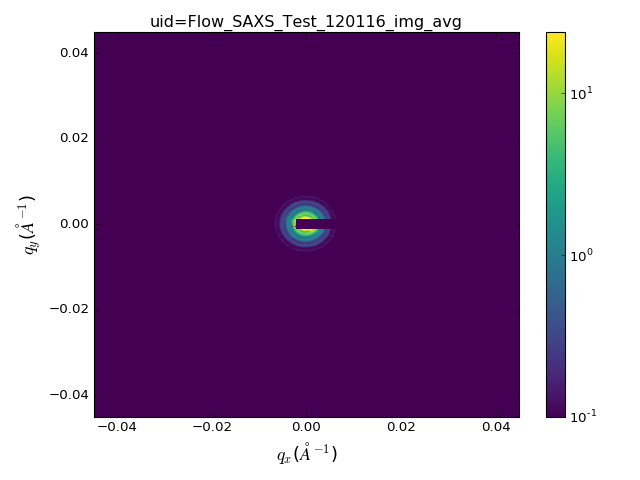

<IPython.core.display.Javascript object>


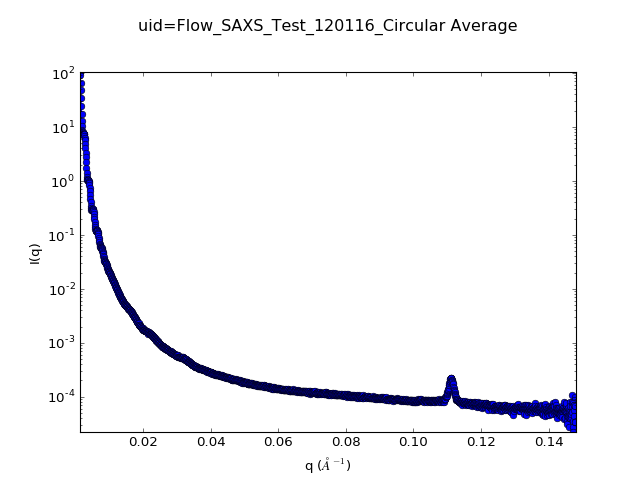

<IPython.core.display.Javascript object>


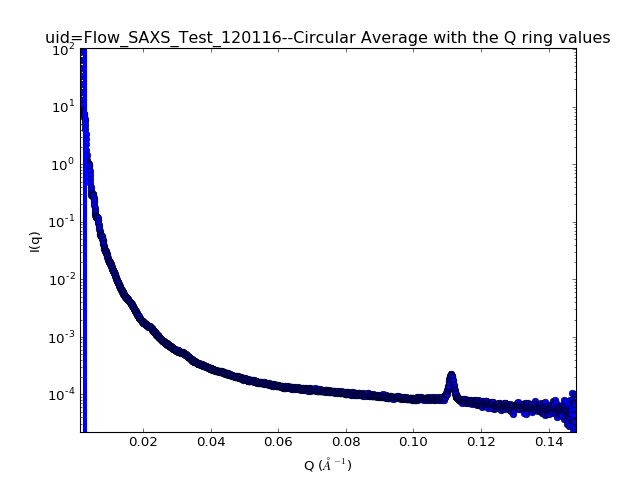

<IPython.core.display.Javascript object>


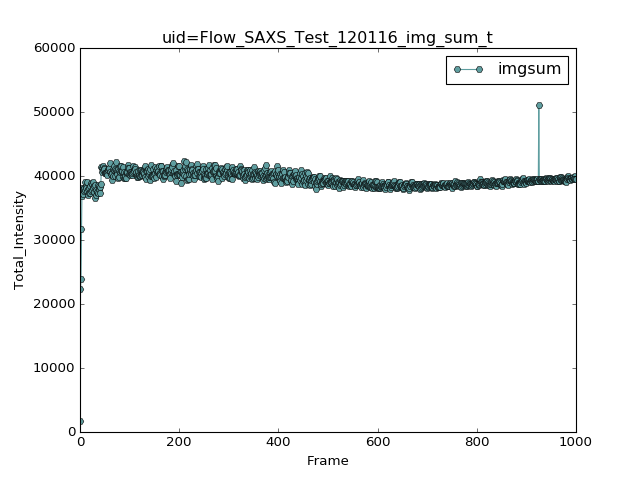

<IPython.core.display.Javascript object>


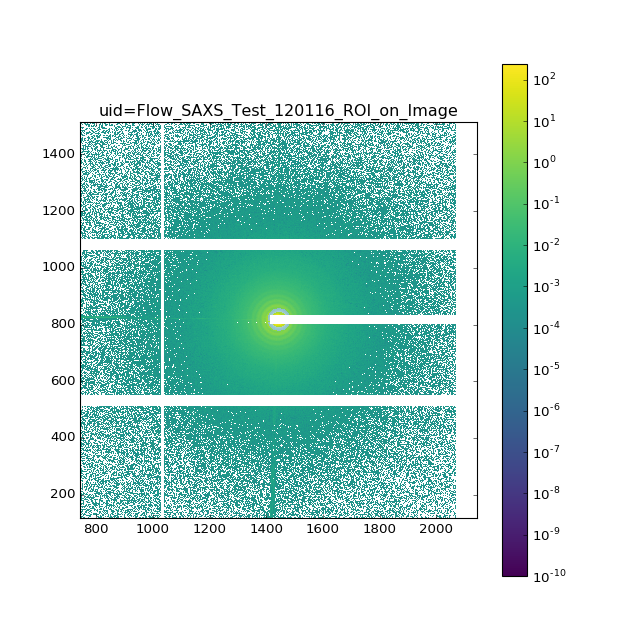

In [79]:
if scat_geometry =='saxs' or 'ang_saxs':
    show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*.1), logs=True,
                   image_name= '%s_img_avg'%uid,  save=True)
    plot_circular_average( q_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                          xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uid, xlim=[q_saxs.min(), q_saxs.max()],
                      ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)
    plot1D( y = imgsum, title ='%s_img_sum_t'%uid, xlabel='Frame', colors='b',
           ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uid, vmin= np.min(avg_img), vmax= np.max(avg_img) )

    if scat_geometry =='saxs':
        plot_t_iqc( qt, iqst, frame_edge=None, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
               ylim = [iqst.min(), iqst.max()], save=True )
    
elif scat_geometry =='gi_saxs':    
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,image_name= uidstr + '_img_avg',  save=True, path=data_dir) 
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )


In [80]:
if run_waterfall: 
    plot_waterfallc( wat, qth_interest, aspect=None,vmax= np.max(wat), uid=uid, save =True, 
                    path=data_dir, beg= good_start)
if run_t_ROI_Inten:
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uid, save=True, path=data_dir )        
      

<IPython.core.display.Javascript object>


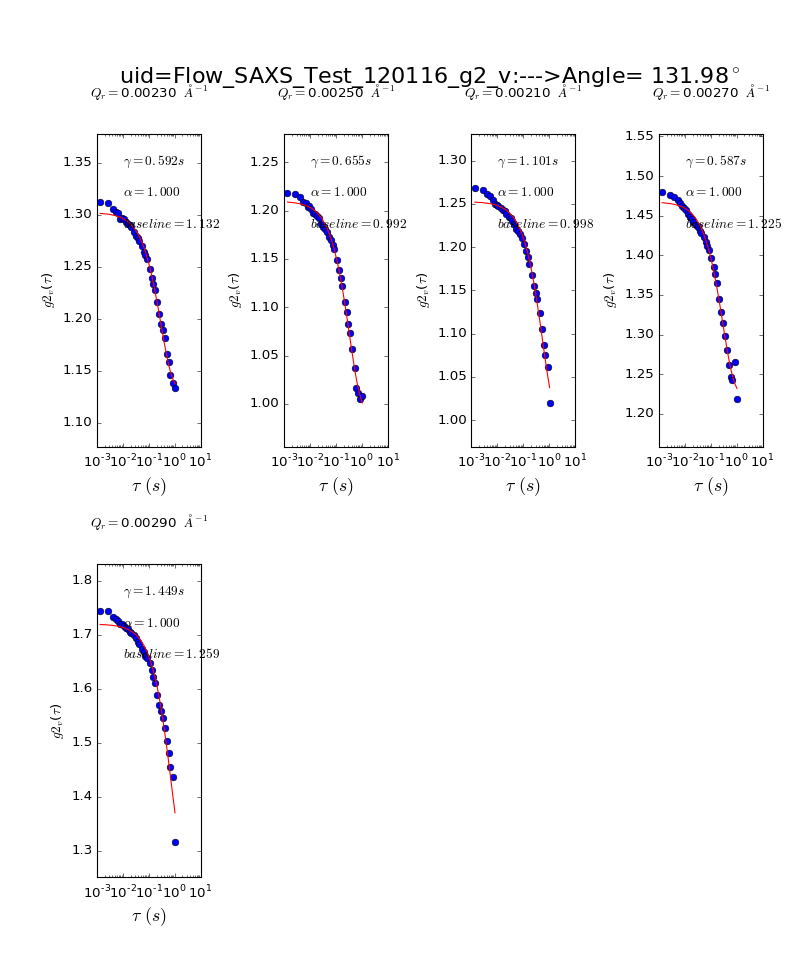

<IPython.core.display.Javascript object>


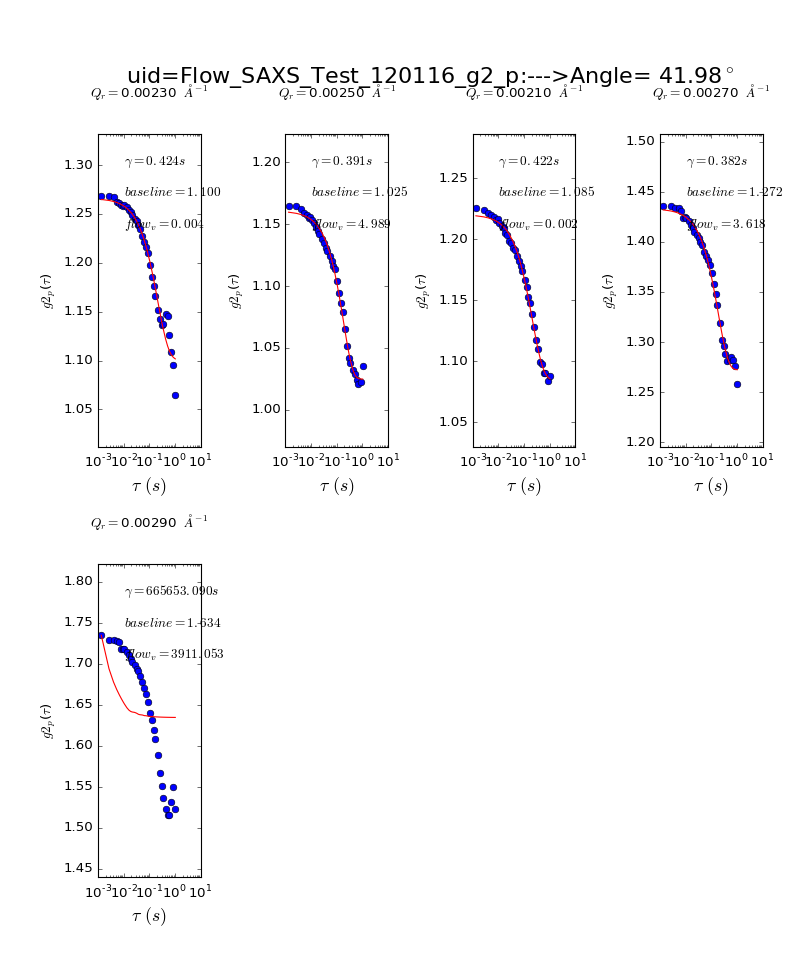

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/uid=Flow_SAXS_Test_120116_g2_fit.png
The fitted diffusion coefficient D0 is:  1.935e+05   A^2S-1


<IPython.core.display.Javascript object>


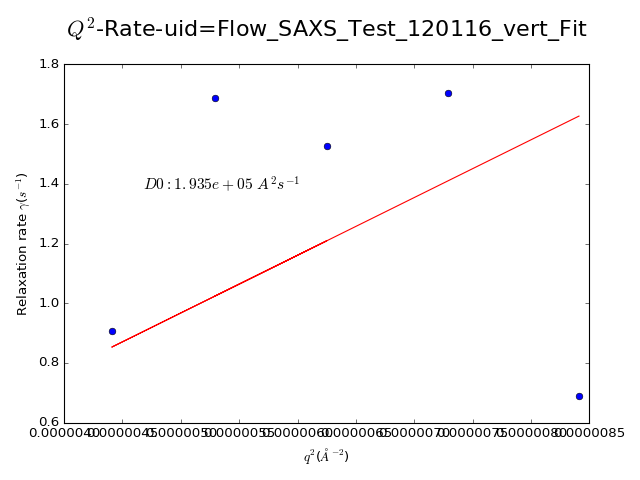

The fitted diffusion coefficient D0 is:  2.757e+05   A^2S-1


<IPython.core.display.Javascript object>


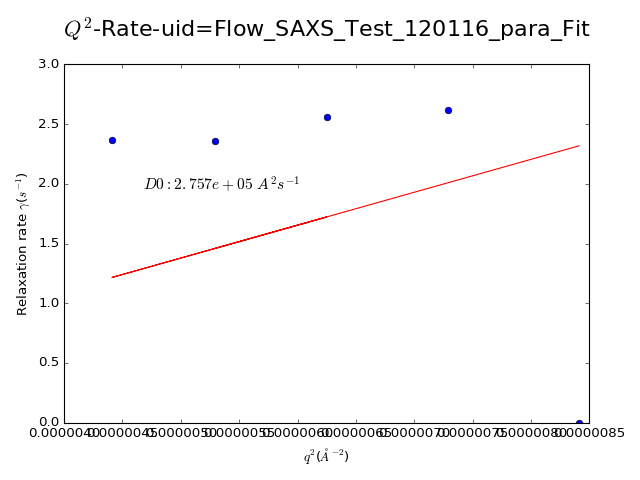

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/uid=Flow_SAXS_Test_120116_Q_Rate_fit.png


In [84]:
if run_one_time:
    if scat_geometry !='ang_saxs':  
        
        plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
                qval_dict = qval_dict, fit_res= g2_fit_result,  geometry=scat_geometry,filename=uid + '_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')

        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res, 
                            geometry= scat_geometry,uid=uid  , path= data_dir )   
        
    else:

        plot_g2_general( g2_dict={1:g2_v, 2:g2_fit_v}, taus_dict={1:taus_v, 2:taus_fit_v},vlim=[0.95, 1.05],
                qval_dict = qval_dict_v, fit_res= g2_fit_result_v,  geometry=scat_geometry,filename= uid+'_g2_v', 
                    path= data_dir, function= fit_g2_func_v,  ylabel='g2_v', append_name=  '_fit')  
        plot_g2_general( g2_dict={1:g2_p, 2:g2_fit_p}, taus_dict={1:taus_p, 2:taus_fit_p},vlim=[0.95, 1.05],
                qval_dict = qval_dict_p, fit_res= g2_fit_result_p,  geometry=scat_geometry,filename= uid+'_g2_p', 
                    path= data_dir, function= fit_g2_func_p,  ylabel='g2_p', append_name=  '_fit') 
        combine_images( [data_dir + uid+'_g2_v_fit.png', data_dir + uid+'_g2_p_fit.png'], data_dir + uid+'_g2_fit.png', outsize=(2000, 2400) )

        D0_v, qrate_fit_res_v = get_q_rate_fit_general(  qval_dict_v, g2_fit_paras_v['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_v, g2_fit_paras_v['relaxation_rate'],  qrate_fit_res_v, 
                    geometry= scat_geometry,uid=uid +'_vert' , path= data_dir )
        D0_p, qrate_fit_res_p = get_q_rate_fit_general(  qval_dict_p, g2_fit_paras_p['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_p, g2_fit_paras_p['relaxation_rate'],  qrate_fit_res_p, 
                    geometry= scat_geometry,uid=uid +'_para' , path= data_dir )
        combine_images( [data_dir + uid+ '_vert_Q_Rate_fit.png', data_dir + uid+ '_para_Q_Rate_fit.png'], data_dir + uid+'_Q_Rate_fit.png', outsize=(2000, 2400) )



In [85]:
if run_two_time:    
    show_C12(g12b, q_ind= qth_interest, N1= 0, N2=min( len(imgsa) ,1000), vmin=1.01, vmax=1.25,
                 timeperframe=timeperframe,save=True,
                 path= data_dir, uid = uid ) 
    plot_g2_general( g2_dict={1:g2b, 2:g2_fitb}, taus_dict={1:tausb, 2:taus_fitb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2_fit_resultb,  geometry=scat_geometry,filename=uid+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')


In [86]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry,filename=uid+'_g2_two_g2', path= data_dir, ylabel='g2', )
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                        geometry=scat_geometry,filename=uid+'_g4',path= data_dir,   ylabel='g4')

In [87]:
if run_xsvs:
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,2.0], qth = qth_interest, uid=uid,path = data_dir, legend_size=14)
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid,path = data_dir, legend_size=4)

## Export Results to a h5 files

In [94]:
md['uid'] = uid
md['suid'] = uid
md['Measurement'] = uid
md['beg'] = None
md['end'] = None
md['bad_frame_list'] = 'unknown'
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + '%s_md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + '%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':  
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum',  'qr_1d_pds'], 
                [md,    roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum,  qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, ] ):
        Exdt[ k ] = v        
elif scat_geometry == 'ang_saxs':     
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','roi_mask_v','roi_mask_p',
                     'qval_dict_v','qval_dict_p','avg_img','mask','pixel_mask', 'imgsum'], 
               [md, q_saxs, iq_saxs, roi_mask_v,roi_mask_p,
                qval_dict_v,qval_dict_p, avg_img,mask,pixel_mask, imgsum] ):
        Exdt[ k ] = v         

if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    if scat_geometry != 'ang_saxs':         
        for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
    else:
        for k,v in zip( ['taus_v','g2_v','g2_fit_paras_v'], [taus_v,g2_v,g2_fit_paras_v] ):Exdt[ k ] = v
        for k,v in zip( ['taus_p','g2_p','g2_fit_paras_p'], [taus_p,g2_p,g2_fit_paras_p] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [95]:
if run_xsvs:
    contr_pds = save_arrays( Exdt['contrast_factorL'], label= Exdt['times_xsvs'],
                       filename = '%s_contr.csv'%uid, path=data_dir,return_res=True )

In [96]:
export_xpcs_results_to_h5( uid + '_Res.h5', data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = uid + '_Res.h5', import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/ with filename as uid=Flow_SAXS_Test_120116_Res.h5


## Create PDF report for each uid

In [97]:
pdf_out_dir = data_dir
pdf_filename = "XPCS_Analysis_Report_for_%s%s.pdf"%(uid_average,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_%s%s.pdf"%(uid_average,pdf_version)

In [98]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

In [99]:
make_pdf_report( data_dir, uid_average, pdf_out_dir, pdf_filename, username, 
                    run_fit_form, run_one_time, run_two_time, run_four_time, run_xsvs, report_type = scat_geometry
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/Flow_SAXS_Test_120116/XPCS_Analysis_Report_for_uid=Flow_SAXS_Test_120116_pipe.pdf
****************************************


### Attach each g2 result to the corresponding olog entry

In [100]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add XPCS Averaged Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Averaged Analysis PDF Report and with the attachments


In [101]:
fuids[-1]

'667327b7-4661-4e5b-9421-ae5d00723086'

# The End!